In [2]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/Dropbox (Personal)/mgbbtopic/"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y_sub.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'E_sub.rds')))
E = E.astype(int)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
E.shape

(34592, 346)

In [5]:

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)


In [7]:
# Get dimensions
N, D, T = Y_tensor.shape
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 20  # number of topics


In [8]:
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/mgbbtopic/diagnames.rds'))
disease_names = disease_names[0].tolist()

In [9]:
# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


Tensor shapes:
Y: torch.Size([34592, 346, 51])
E: torch.Size([34592, 346])
Time range: 0 to 50
51
20


In [10]:
E_tensor 

tensor([[50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        ...,
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.],
        [50., 50., 50.,  ..., 50., 50., 50.]])

In [13]:

# G should be float64
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'G_sub.rds')))
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)
G_tensor = torch.FloatTensor(G)
print(f"G: {G_tensor.shape}")  # [N, P]

G shape after transposition: (34592, 36)
G: torch.Size([34592, 36])


In [23]:
from cluster_g_logit_init_acceptpsi import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [24]:
Y = torch.tensor(Y, dtype=torch.float32)
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_35434/808097325.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


In [25]:
prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
epsilon = 1e-8
logit_prev_t = torch.log((prevalence_t + epsilon) / (1 - prevalence_t + epsilon))
lambda_length_scale = T/4

Y_avg = torch.mean(Y, dim=2)
epsilon=1e-8
Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))
Y_corr = torch.corrcoef(Y_avg.T)
similarity = (Y_corr + 1) / 2
            
spectral = SpectralClustering(
    n_clusters=K,
    assign_labels='kmeans',
    affinity='precomputed',
    n_init=10,
    random_state=42
).fit(similarity.numpy())

clusters=spectral.labels_

Y_avg = torch.mean(Y, dim=2)
        
print("\nCluster Assignments:")
for k in range(K):
    print(f"\nCluster {k}:")
    cluster_diseases = [disease_names[i] for i in range(len(clusters)) 
                    if clusters[i] == k]
    # Get prevalence for each disease
    cluster_mask = (clusters == k)
    prevalences = Y_avg[:, cluster_mask].mean(dim=0)
    
    for disease, prev in zip(cluster_diseases, prevalences):
        print(f"  - {disease} (prevalence: {prev:.4f})")


Cluster Assignments:

Cluster 0:
  - Septal Deviations/Turbinate Hypertrophy (prevalence: 0.0010)
  - Nasal polyps (prevalence: 0.0002)
  - Chronic pharyngitis and nasopharyngitis (prevalence: 0.0011)
  - Chronic sinusitis (prevalence: 0.0016)
  - Allergic rhinitis (prevalence: 0.0029)
  - Other upper respiratory disease (prevalence: 0.0022)

Cluster 1:
  - Viral infection (prevalence: 0.0019)
  - Hypopotassemia (prevalence: 0.0014)
  - Obesity (prevalence: 0.0050)
  - Bipolar (prevalence: 0.0012)
  - Major depressive disorder (prevalence: 0.0055)
  - Anxiety disorder (prevalence: 0.0059)
  - Alcohol-related disorders (prevalence: 0.0015)
  - Alcoholic liver damage (prevalence: 0.0003)
  - Tobacco use disorder (prevalence: 0.0021)
  - Sleep disorders (prevalence: 0.0012)
  - Sleep apnea (prevalence: 0.0039)
  - Migraine (prevalence: 0.0024)
  - Inflammatory and toxic neuropathy (prevalence: 0.0022)
  - Angina pectoris (prevalence: 0.0035)
  - Acute upper respiratory infections of mult

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_35434/1352526393.py:196: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()



Cluster Memberships:

Cluster 0 (6 diseases):
  - Septal Deviations/Turbinate Hypertrophy
  - Nasal polyps
  - Chronic pharyngitis and nasopharyngitis
  - Chronic sinusitis
  - Allergic rhinitis
  - Other upper respiratory disease

Cluster 1 (28 diseases):
  - Viral infection
  - Hypopotassemia
  - Obesity
  - Bipolar
  - Major depressive disorder
  - Anxiety disorder
  - Alcohol-related disorders
  - Alcoholic liver damage
  - Tobacco use disorder
  - Sleep disorders
  - Sleep apnea
  - Migraine
  - Inflammatory and toxic neuropathy
  - Angina pectoris
  - Acute upper respiratory infections of multiple or unspecified sites
  - Acute pharyngitis
  - Asthma
  - Dental caries
  - Periapical abscess
  - Chronic periodontitis
  - Other diseases of the teeth and supporting structures
  - GERD
  - Constipation
  - Irritable Bowel Syndrome
  - Other chronic nonalcoholic liver disease
  - Other disorders of liver
  - Cervicalgia
  - Myalgia and myositis unspecified

Cluster 2 (24 diseases):
 

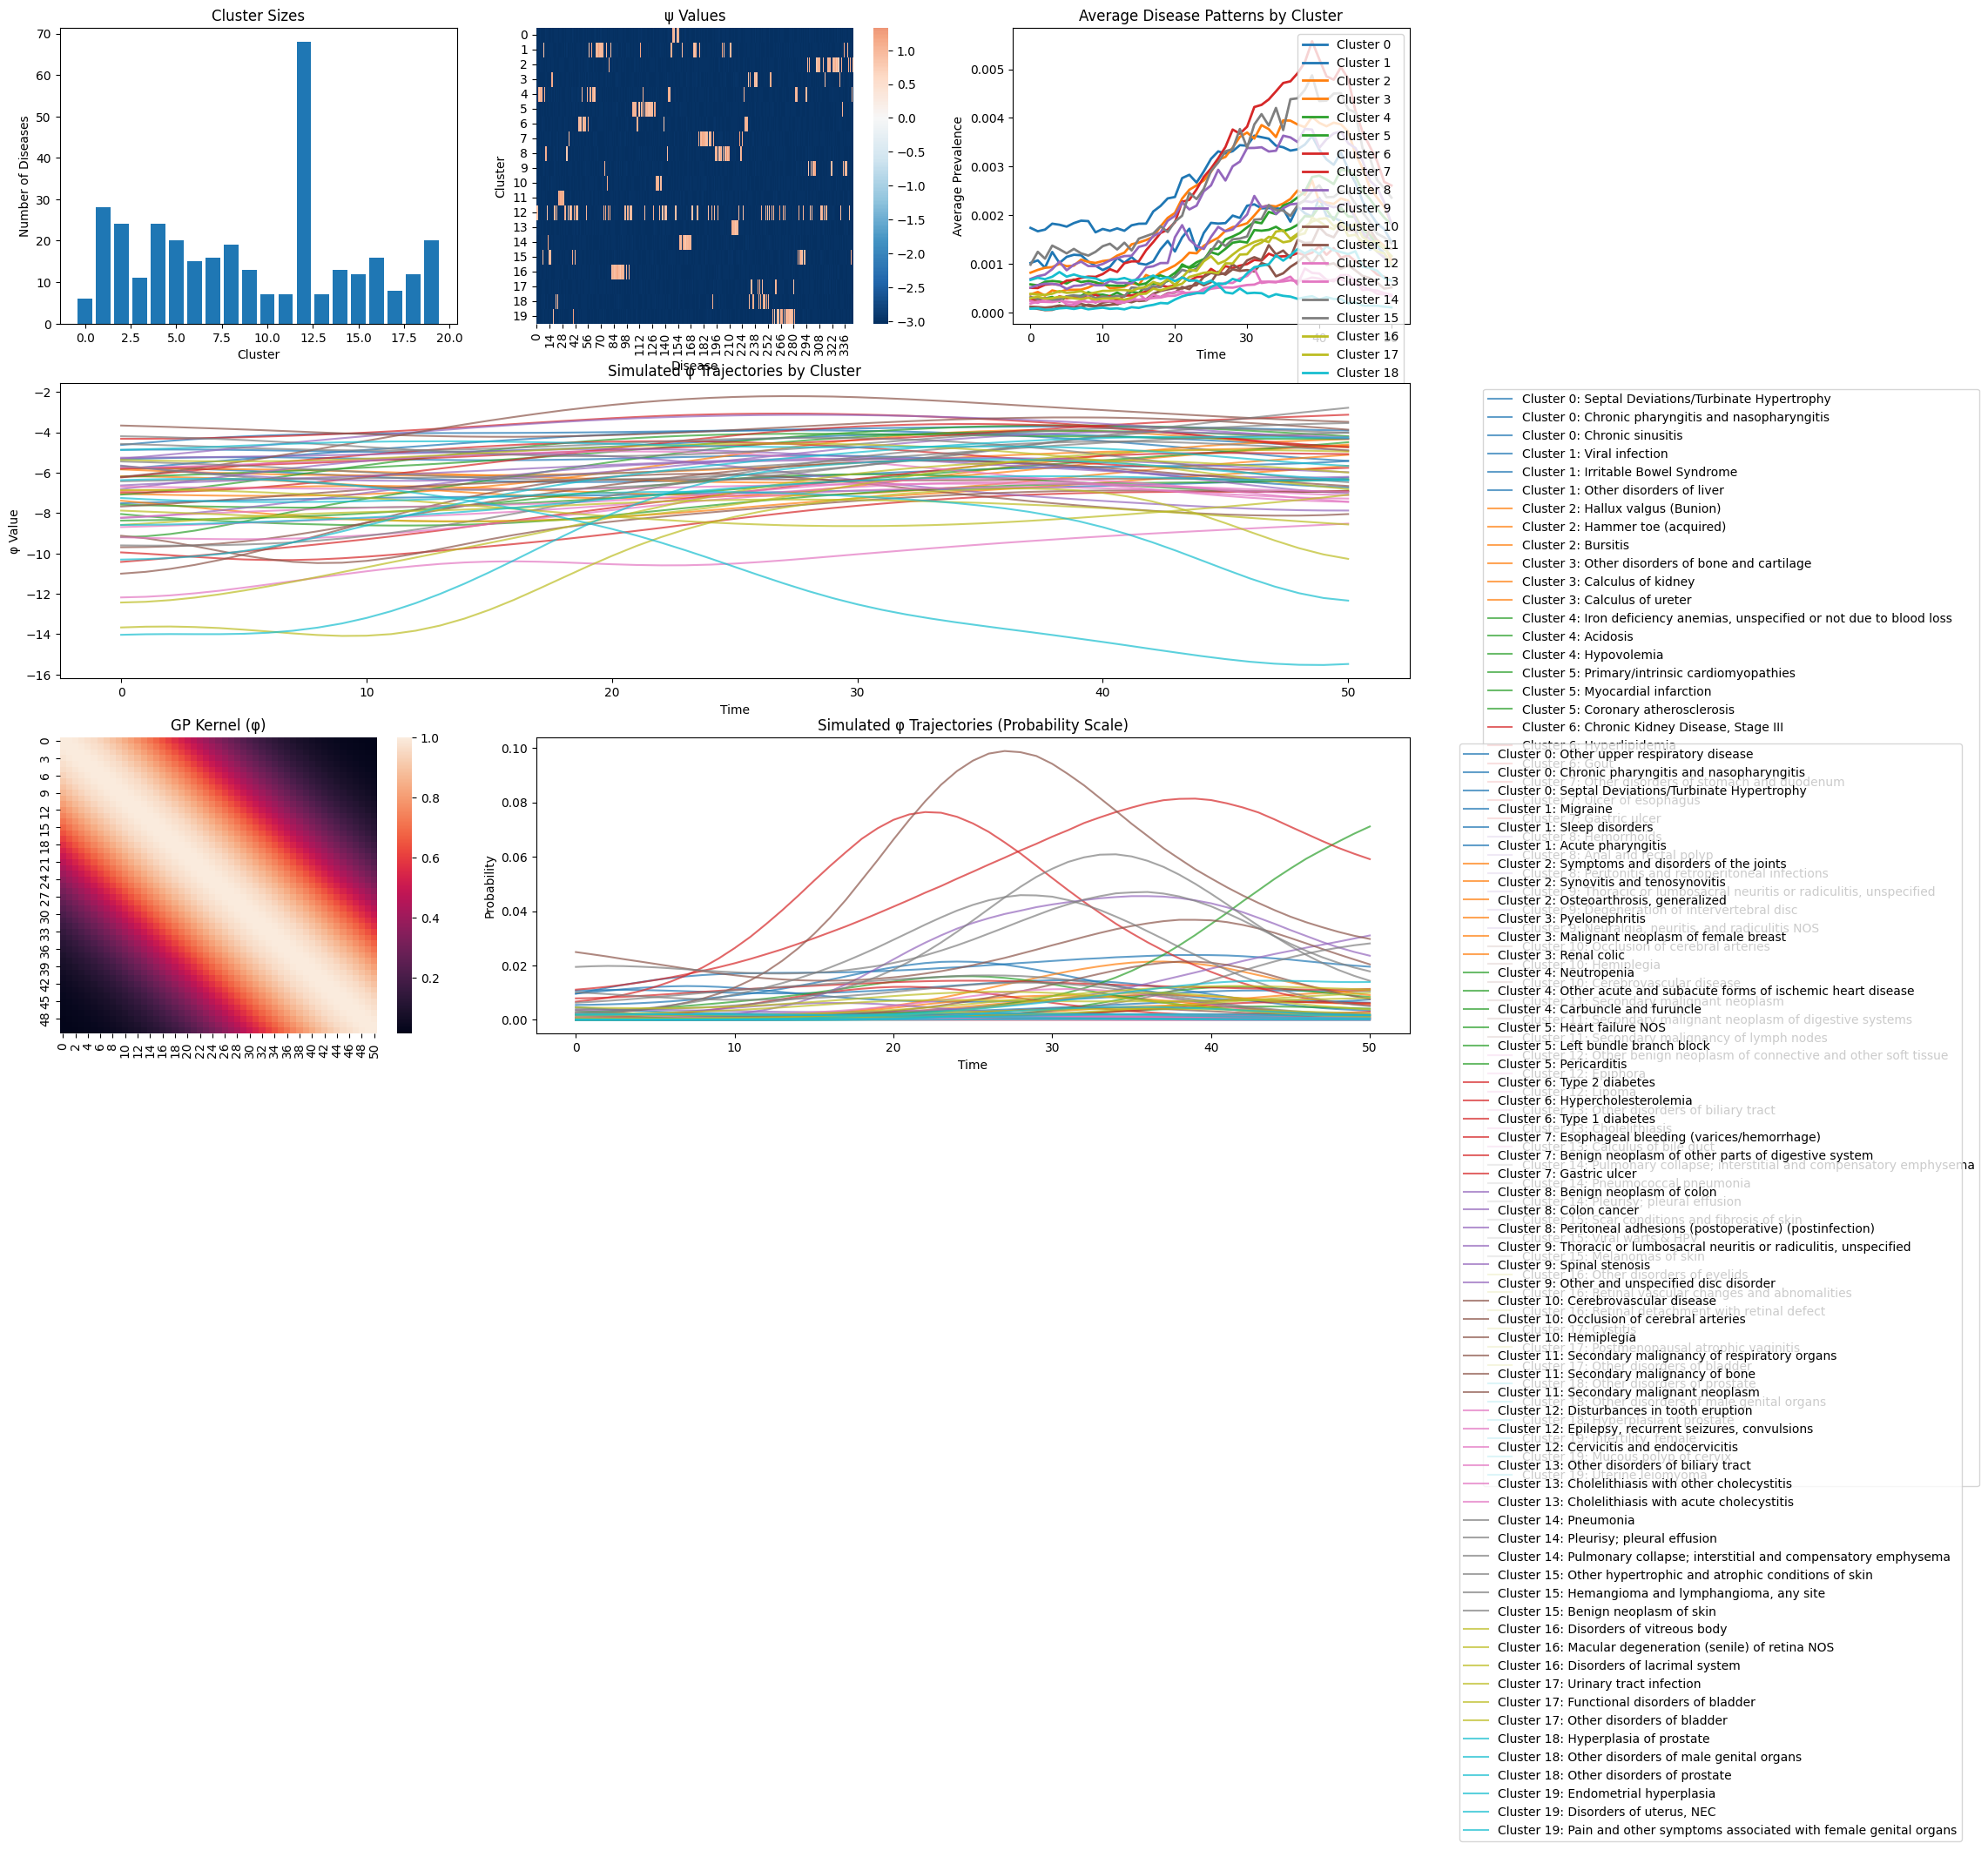

In [18]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
epsilon = 1e-8
logit_prev_t = torch.log((prevalence_t + epsilon) / (1 - prevalence_t + epsilon))

K=20
# Create model
def initialize_disease_clusters(Y, K, T, logit_prev_t, disease_names=None, random_state=42):
    """
    Initialize disease clusters and simulate phi trajectories using GP prior
    
    Parameters:
    Y: numpy array (N x D x T) of disease trajectories
    K: int, number of clusters
    T: int, number of time points
    logit_prev_t: tensor (D x T) of logit prevalence trajectories
    disease_names: list of disease names (optional)
    random_state: int, random seed for reproducibility
    """
    # Convert inputs to torch tensors if needed
    if not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y, dtype=torch.float32)
    if not isinstance(logit_prev_t, torch.Tensor):
        logit_prev_t = torch.tensor(logit_prev_t, dtype=torch.float32)
    
    N, D, T = Y.shape
    
    # Set kernel parameters as in the model
    lambda_length_scale = T/4
    phi_length_scale = T/3
    amplitude = 1.0
    
    # Compute kernel matrices
    times = torch.arange(T, dtype=torch.float32)
    sq_dists = (times.unsqueeze(0) - times.unsqueeze(1)) ** 2
    K_phi = amplitude ** 2 * torch.exp(-0.5 * sq_dists / (phi_length_scale ** 2))
    jitter = 1e-6
    K_phi = K_phi + jitter * torch.eye(T)
    
    # Perform clustering as before
    Y_avg = torch.mean(Y, dim=2)
    epsilon = 1e-8
    Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))
    
    Y_corr = torch.corrcoef(Y_avg.T)
    similarity = (Y_corr + 1) / 2
    
    spectral = SpectralClustering(
        n_clusters=K,
        assign_labels='kmeans',
        affinity='precomputed',
        n_init=10,
        random_state=random_state
    ).fit(similarity.numpy())
    
    clusters = spectral.labels_
    
    # Initialize psi
    psi = torch.zeros((K, D))
    for k in range(K):
        cluster_mask = (clusters == k)
        psi[k, cluster_mask] = 1.0 + 0.1 * torch.randn(cluster_mask.sum())
        psi[k, ~cluster_mask] = -3.0 + 0.01 * torch.randn((~cluster_mask).sum())
    
    # Simulate phi using GP prior
    L_phi = torch.linalg.cholesky(K_phi)
    phi = torch.zeros((K, D, T))
    
    for k in range(K):
        for d in range(D):
            mean_phi = logit_prev_t[d, :] + psi[k, d]
            eps = L_phi @ torch.randn(T)
            phi[k, d, :] = mean_phi + eps
    
    # Store cluster information
    cluster_info = {
        'sizes': {},
        'members': {},
        'avg_trajectories': {}
    }
    
    unique, counts = np.unique(clusters, return_counts=True)
    for k, count in zip(unique, counts):
        cluster_info['sizes'][k] = count.item()
        cluster_mask = (clusters == k)
        
        if disease_names is not None:
            members = [disease_names[i] for i in range(D) if cluster_mask[i]]
        else:
            members = [i for i in range(D) if cluster_mask[i]]
        
        cluster_info['members'][k] = members
        cluster_info['avg_trajectories'][k] = Y_avg[:, cluster_mask].mean(dim=1)
    
    return {
        'clusters': clusters,
        'psi': psi,
        'phi': phi,
        'cluster_info': cluster_info,
        'K_phi': K_phi
    }




def plot_cluster_results(cluster_results, Y, disease_names=None, n_example_trajectories=3):
    """
    Visualize clustering results including simulated phi trajectories
    """
    K = cluster_results['psi'].shape[0]
    D = Y.shape[1]
    T = Y.shape[2]
    
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 3)
    
    # Plot 1: Cluster sizes
    ax1 = fig.add_subplot(gs[0, 0])
    sizes = list(cluster_results['cluster_info']['sizes'].values())
    ax1.bar(range(K), sizes)
    ax1.set_title('Cluster Sizes')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Number of Diseases')
    
    # Plot 2: Psi heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(cluster_results['psi'].numpy(), 
                cmap='RdBu_r', 
                center=0,
                ax=ax2)
    ax2.set_title('ψ Values')
    ax2.set_xlabel('Disease')
    ax2.set_ylabel('Cluster')
    
    # Plot 3: Average temporal patterns
    ax3 = fig.add_subplot(gs[0, 2])
    Y_avg = torch.mean(Y, dim=0).numpy()
    clusters = cluster_results['clusters']
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_avg = Y_avg[cluster_mask].mean(axis=0)
        ax3.plot(cluster_avg, color=colors[k], label=f'Cluster {k}', linewidth=2)
    ax3.set_title('Average Disease Patterns by Cluster')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Average Prevalence')
    ax3.legend()
    
    # Plot 4: Simulated phi trajectories
    ax4 = fig.add_subplot(gs[1, :])
    phi = cluster_results['phi']
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        # Select random examples
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax4.plot(phi[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax4.set_title('Simulated φ Trajectories by Cluster')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('φ Value')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 5: GP kernel
    ax5 = fig.add_subplot(gs[2, 0])
    sns.heatmap(cluster_results['K_phi'].numpy(), ax=ax5)
    ax5.set_title('GP Kernel (φ)')
    
    # Plot transformed phi (probability scale)
    ax6 = fig.add_subplot(gs[2, 1:])
    phi_prob = torch.sigmoid(phi)
    
    for k in range(K):
        cluster_mask = (clusters == k)
        cluster_diseases = np.where(cluster_mask)[0]
        
        n_examples = min(n_example_trajectories, len(cluster_diseases))
        example_diseases = np.random.choice(cluster_diseases, n_examples, replace=False)
        
        for d in example_diseases:
            label = f'Cluster {k}: ' + (disease_names[d] if disease_names is not None else f'Disease {d}')
            ax6.plot(phi_prob[k, d, :].numpy(), color=colors[k], alpha=0.7, label=label)
    
    ax6.set_title('Simulated φ Trajectories (Probability Scale)')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Probability')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Print cluster memberships
    print("\nCluster Memberships:")
    for k in range(K):
        print(f"\nCluster {k} ({cluster_results['cluster_info']['sizes'][k]} diseases):")
        members = cluster_results['cluster_info']['members'][k]
        if disease_names is not None:
            for member in members:
                print(f"  - {member}")
    
    plt.show()

# Example usage:

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_cluster_results(cluster_results, Y, disease_names)


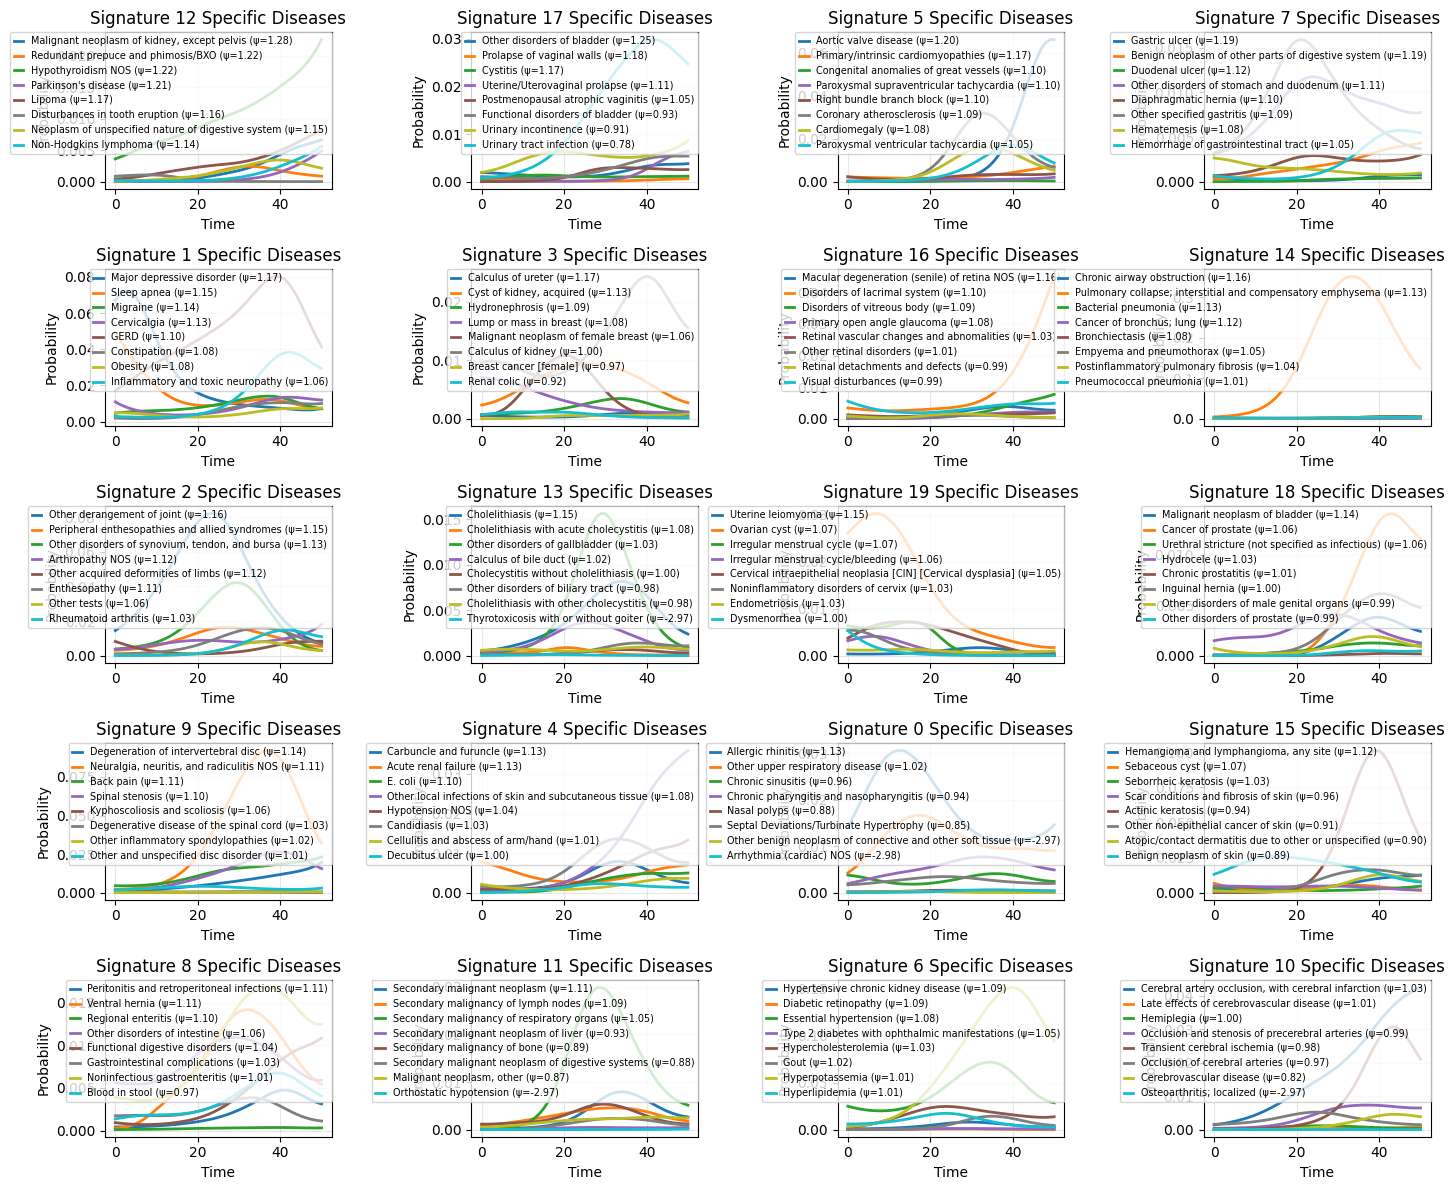

In [19]:
def plot_signature_trajectories(cluster_results, n_signatures=20, n_top_diseases=5, disease_names=None):
    """
    Plot phi trajectories for signature-specific diseases in selected clusters
    
    Parameters:
    cluster_results: output from initialize_disease_clusters
    n_signatures: number of signatures (clusters) to plot
    n_top_diseases: number of most signature-specific diseases to show per cluster
    disease_names: list of disease names (optional)
    """
    K = cluster_results['psi'].shape[0]
    phi = cluster_results['phi']
    psi = cluster_results['psi']
    
    # Select clusters with most distinct patterns (highest psi values)
    cluster_specificity = torch.max(psi, dim=1)[0]  # Maximum psi value per cluster
    top_clusters = torch.argsort(cluster_specificity, descending=True)[:n_signatures]
    
    # Create subplot grid
    fig, axes = plt.subplots(5, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_top_diseases))
    
    for idx, k in enumerate(top_clusters):
        ax = axes[idx]
        
        # Find most specific diseases for this signature
        psi_k = psi[k, :]
        top_diseases = torch.argsort(psi_k, descending=True)[:n_top_diseases]
        
        # Plot phi trajectories
        for i, d in enumerate(top_diseases):
            phi_trajectory = phi[k, d, :].numpy()
            prob_trajectory = torch.sigmoid(phi[k, d, :]).numpy()
            
            label = f"{disease_names[d] if disease_names is not None else f'Disease {d}'} (ψ={psi_k[d]:.2f})"
            
            # Plot on probability scale
            ax.plot(prob_trajectory, color=colors[i], linewidth=2, label=label)
        
        ax.set_title(f'Signature {k} Specific Diseases')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        # Modify legend parameters to fit within each subplot
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                 fontsize='x-small',  # Make font smaller
                 framealpha=0.8,      # Make background slightly transparent
                 handlelength=1,      # Shorter lines in legend
                 borderaxespad=0.)    # Reduce padding
        ax.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave some space on the right
    plt.show()

cluster_results = initialize_disease_clusters(
    Y=Y,
    K=20,
    T=T,
    logit_prev_t=logit_prev_t,
    disease_names=disease_names
)

plot_signature_trajectories(
    cluster_results,
    n_signatures=20,
    n_top_diseases=8,
    disease_names=disease_names
)


In [26]:
psi_config = {'in_cluster': 1, 'out_cluster': -2, 'noise_in': 0.1, 'noise_out': 0.01}



# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


K=20;P=G.shape[1]

model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
N=Y.shape[0],
D=Y.shape[1],
T=Y.shape[2],
K=K,
P=P,
G=G,
Y=Y,
prevalence_t=prevalence_t,
)

model.initialize_params(psi_config=psi_config)

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)


Lambda kernel condition number: 45200668.00
Phi kernel condition number: 89734320.00

Cluster Sizes:
Cluster 0: 6 diseases
Cluster 1: 28 diseases
Cluster 2: 24 diseases
Cluster 3: 11 diseases
Cluster 4: 24 diseases
Cluster 5: 20 diseases
Cluster 6: 15 diseases
Cluster 7: 16 diseases
Cluster 8: 19 diseases
Cluster 9: 13 diseases
Cluster 10: 7 diseases
Cluster 11: 7 diseases
Cluster 12: 68 diseases
Cluster 13: 7 diseases
Cluster 14: 13 diseases
Cluster 15: 12 diseases
Cluster 16: 16 diseases
Cluster 17: 8 diseases
Cluster 18: 12 diseases
Cluster 19: 20 diseases
Initialization complete!

Using psi configuration
Initialization complete!



G matrix scaling check:
Mean should be ~0: 0.000000
Std should be ~1: 0.000014


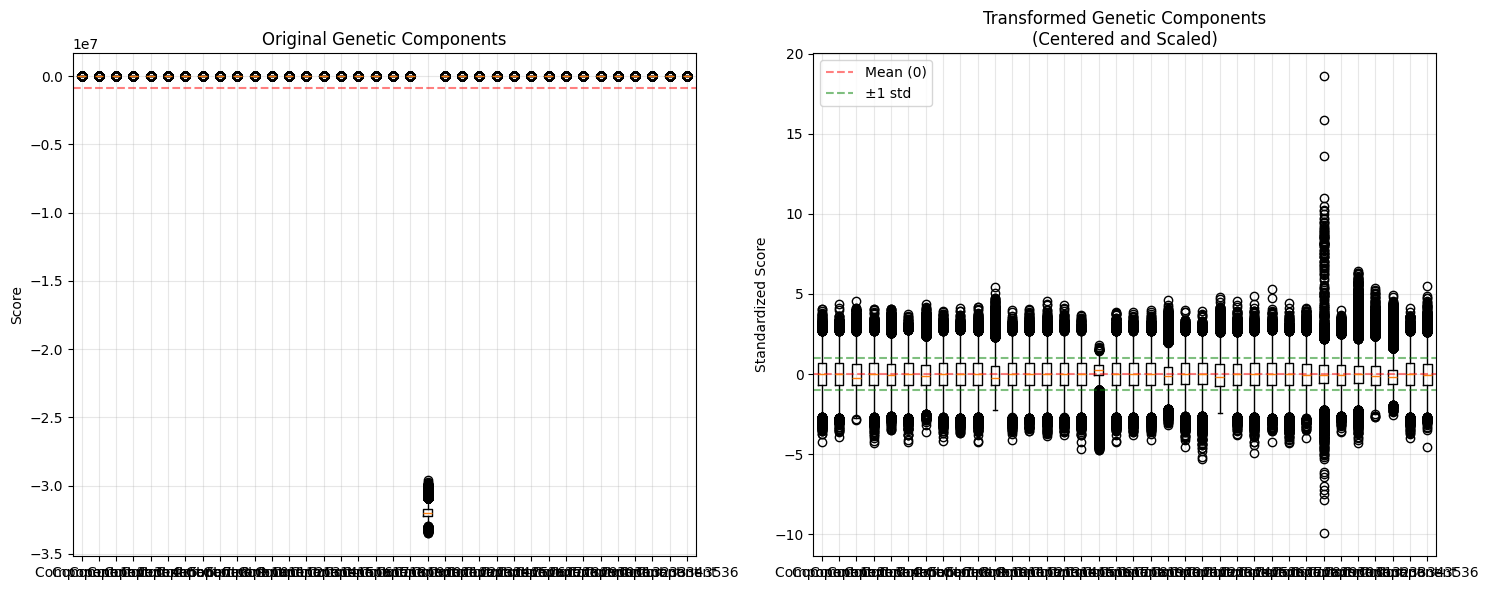


Genetic Components Summary Statistics:
Component  Original Mean Original Std  Trans. Mean  Trans. Std
------------------------------------------------------------
1                 -3.626        1.247        0.000       1.000
2                  4.449        0.507       -0.000       1.000
3                  2.763        0.700        0.000       1.000
4                 -0.742        0.392        0.000       1.000
5                 -3.008        0.119       -0.000       1.000
6                 -0.065        0.211        0.000       1.000
7                 -1.780        0.188       -0.000       1.000
8                 -0.050        0.006       -0.000       1.000
9                 -2.896        0.584       -0.000       1.000
10                13.448        0.860        0.000       1.000
11                -0.044        0.008        0.000       1.000
12               -14.494        0.796        0.000       1.000
13               -12.503        1.334        0.000       1.000
14               

In [34]:
# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")
# When initializing the model:




# Plot both versions:
model.plot_genetic_scores(G)
print(model.G[:,3].mean())

print(G[:,3].mean())


# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")



In [35]:
history = model.fit(E, num_epochs=200, learning_rate=1e-4, lambda_reg=1e-2)

Starting training...
mask_before_event shape: torch.Size([34592, 346, 51])
mask_at_event shape: torch.Size([34592, 346, 51])

Epoch 0
Loss: 1188.9941
Psi gradient stats:
Mean: 3.9109e-05
Std:  4.7390e-03
Max:  1.7437e-02
Min:  -1.5751e-02
Epoch 0, Loss: 1188.9941, Gradients - Lambda: 1.597e-01, Phi: 1.427e+01, Gamma: 2.889e-02, Psi: 1.744e-02
mask_before_event shape: torch.Size([34592, 346, 51])
mask_at_event shape: torch.Size([34592, 346, 51])

Epoch 1
Loss: 1045.2201
Psi gradient stats:
Mean: 3.8785e-05
Std:  4.7311e-03
Max:  1.7439e-02
Min:  -1.5761e-02
Epoch 1, Loss: 1045.2201, Gradients - Lambda: 1.538e-01, Phi: 1.373e+01, Gamma: 2.837e-02, Psi: 1.744e-02

Estimated total training time: 791.5 minutes
mask_before_event shape: torch.Size([34592, 346, 51])
mask_at_event shape: torch.Size([34592, 346, 51])

Epoch 2
Loss: 922.6069
Psi gradient stats:
Mean: 3.8558e-05
Std:  4.7235e-03
Max:  1.7455e-02
Min:  -1.5756e-02
Epoch 2, Loss: 922.6069, Gradients - Lambda: 1.478e-01, Phi: 1.328e+

In [54]:
model_save_path = os.path.join("/Users/sarahurbut/Dropbox (Personal)/mgbbtopic", 'model.pt')
    # Save model and results
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'psi': model.psi,
    'Y': Y,
    'prevalence_t': prevalence_t,
    'logit_prevalence_t': model.logit_prev_t,
    'G': G,
    'E': E,
   
    'disease_names': disease_names,
    'hyperparameters': {
        'N': Y[0],
        'D': Y.shape[1],
        'T': Y.shape[2],
        'P': G.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)

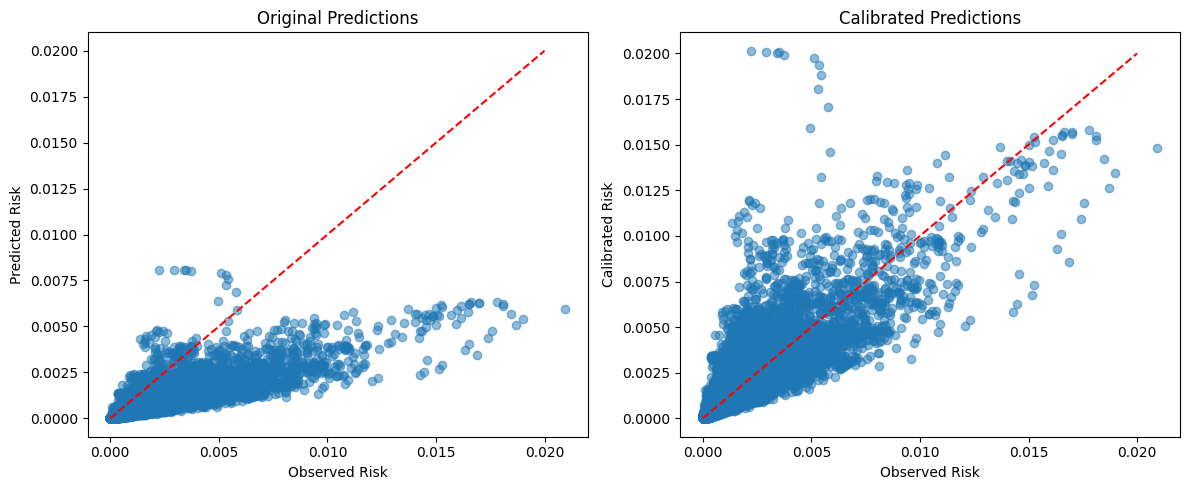

Mean observed risk: 0.001297
Mean predicted risk (original): 0.000521
Mean predicted risk (calibrated): 0.001297
Calibration scale factor: 2.489
R^2: 0.692


In [38]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")


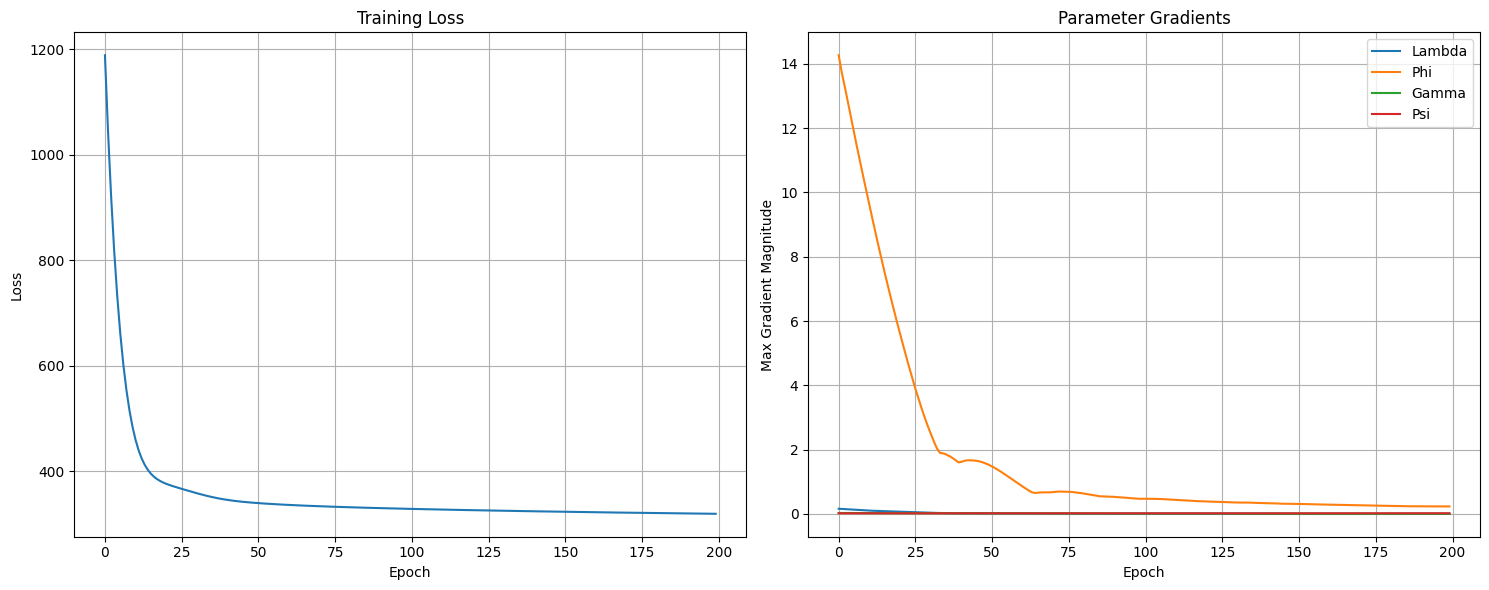

In [55]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [40]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, disease_names=disease_names, n_top=10)


Top 10 diseases in Signature 0 (relative to baseline):
Other upper respiratory disease: effect=2.106 (OR=8.21), std=0.797
Septal Deviations/Turbinate Hypertrophy: effect=1.983 (OR=7.27), std=0.745
Chronic pharyngitis and nasopharyngitis: effect=1.410 (OR=4.10), std=0.271
Allergic rhinitis: effect=0.677 (OR=1.97), std=0.365
Nasal polyps: effect=0.373 (OR=1.45), std=0.902
Type 1 diabetes: effect=0.199 (OR=1.22), std=0.549
Chronic sinusitis: effect=0.072 (OR=1.07), std=0.353
Raynaud's syndrome: effect=0.021 (OR=1.02), std=0.103
Rheumatic disease of the heart valves: effect=-0.188 (OR=0.83), std=0.521
Hallux rigidus: effect=-0.247 (OR=0.78), std=0.475

Top 10 diseases in Signature 1 (relative to baseline):
Hypopotassemia: effect=2.505 (OR=12.25), std=1.049
Migraine: effect=2.204 (OR=9.06), std=0.344
Acute upper respiratory infections of multiple or unspecified sites: effect=1.992 (OR=7.33), std=0.292
Viral infection: effect=1.912 (OR=6.77), std=0.314
Irritable Bowel Syndrome: effect=1.765

In [46]:
len(disease_names)

346

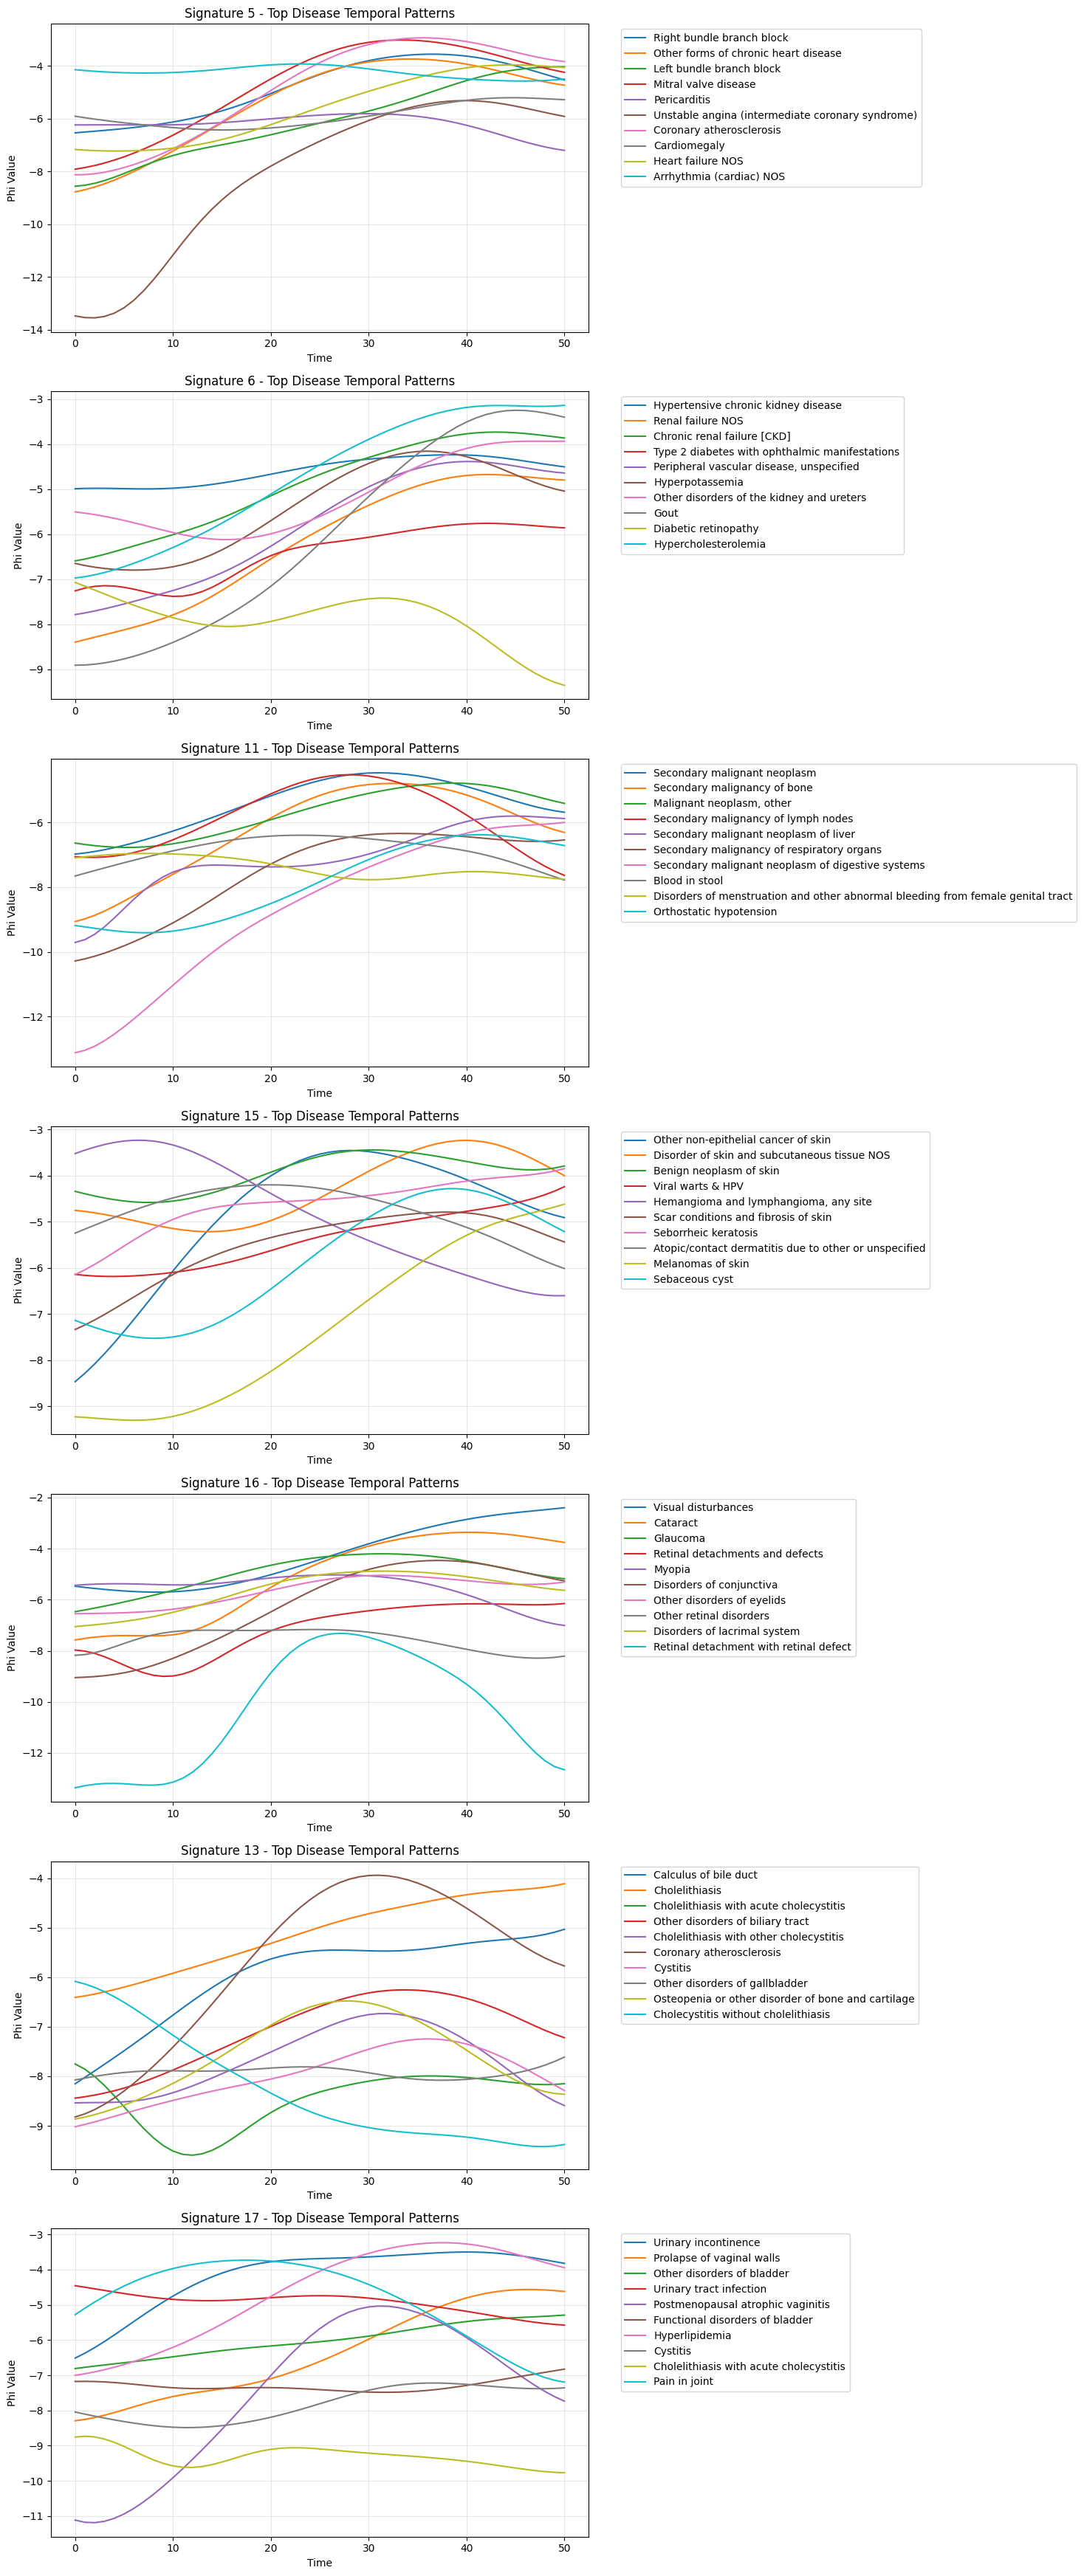

In [48]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:

plot_signature_temporal_patterns(model, disease_names, selected_signatures=[5,6,11,15,16,13,17])

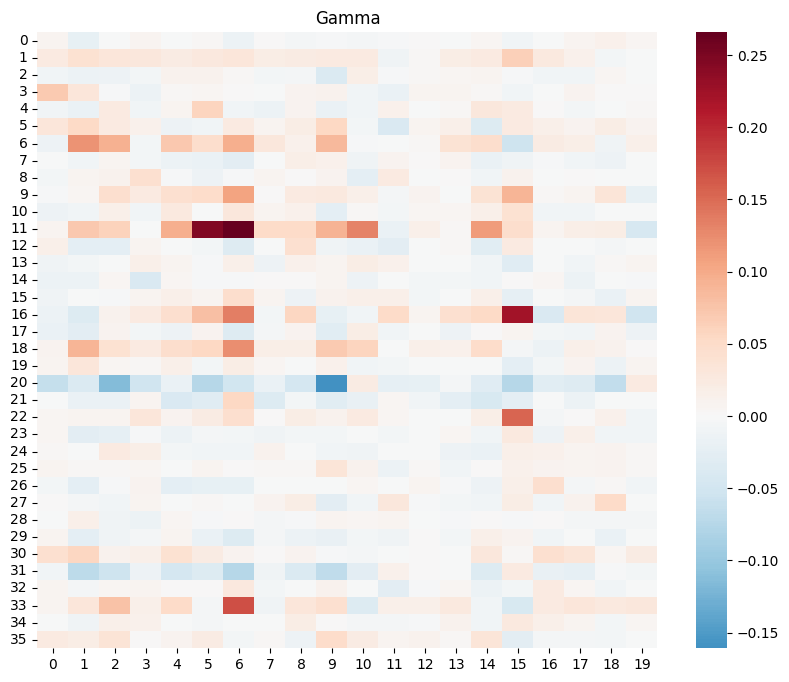

In [51]:
plt.figure(figsize=(10, 8))
diff = model.gamma.detach().numpy() 
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Gamma')
plt.show()